# Results Summary

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
from itertools import product

In [2]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [3]:
sns.set_context('talk')

In [4]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']

## Vision Models

### Behavior

In [88]:
files = glob(f'../data/interim/VisionBehaviorEncoding/grouped_average/*.*.gz')
files.sort(key=os.path.getmtime)
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [6]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

          feature  reliabilty
0         expanse    0.719483
1          object    0.928456
2  agent_distance    0.885451
3      facingness    0.957481
4    joint_action    0.768867
5   communication    0.762171
6         valence    0.747964
7         arousal    0.683388

/tmp/ipykernel_364818/793085878.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


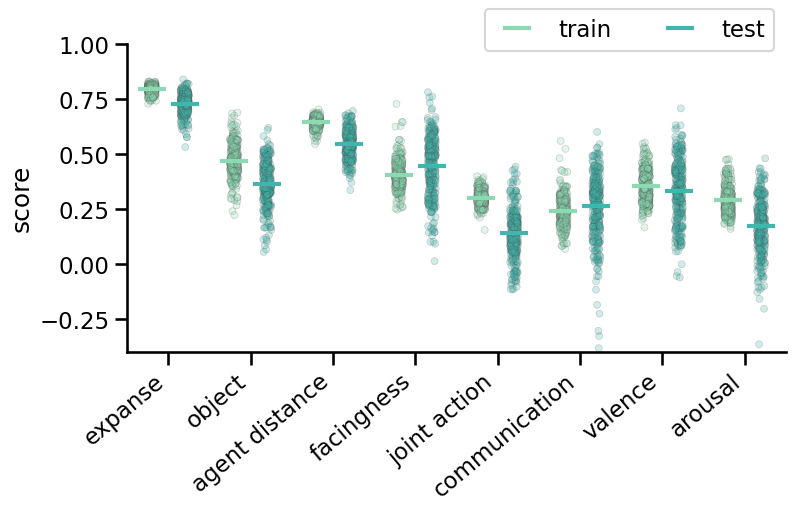

In [7]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']

sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xlabel('')
ax.set_ylim([-.4, 1])
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
          ncol=2, fancybox=True)

### Neural

In [18]:
# files = glob(f'../data/interim/VisionNeuralEncoding/grouped_average/*.pkl.gz')
# files += glob(f'../data/interim/VisionNeuralEncoding/grouped_stack/*.pkl.gz')
# df = []
# for file in files:
#     cur = pd.read_pickle(file)
#     cur.drop(columns=['r_null_dist', 'r_var_dist'], inplace=True)
#     if 'grouped_stack' in file:
#         cur['combine_method'] = 'stack'
#     else:
#         cur['combine_method'] = 'average'
#     df.append(cur)
# df = pd.concat(df)
# df['model_uid'] = df['model_uid'] + df['combine_method']

In [ ]:
# files = glob(f'../data/interim/VisionNeuralEncoding_old/*.csv.gz')
# print(f'{len(files)} neural encoding models found')
# df = []
# for file in tqdm(files):
#     cdf = pd.read_csv(file)
#     df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
# df = pd.concat(df).reset_index(drop=True)

In [10]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

In [11]:
model_uids_to_annotate = ['torchvision_alexnet_imagenet1k_v1', 'slip_vit_b_clip_yfcc15m']
model_uids_to_annotate += [max_scores[(max_scores.roi_name == 'pSTS') & (max_scores.set == 'test')].max()['model_uid']]
model_name_to_show = ['alexnet', 'clip']
model_name_to_show += [max_scores[(max_scores.roi_name == 'pSTS') & (max_scores.set == 'test')].max()['model_uid']]
rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
offset_positions = [(-20,-25), (-15, 55), (15,70)]
offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
annotation_roi = 'pSTS'
annotation_set = 'test'

/tmp/ipykernel_1715964/3215872031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_1715964/3215872031.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_1715964/3215872031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


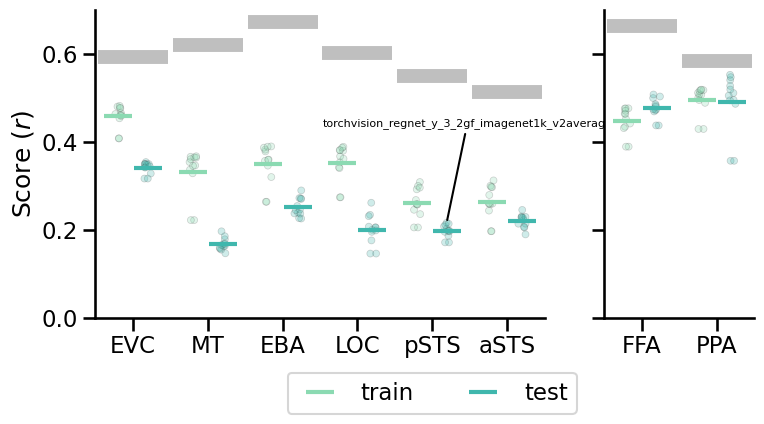

In [12]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=30, markeredgewidth=10,
                  color='gray', alpha=.5, zorder=1)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    
    dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter
    roi_positions = {roi: i for i, roi in enumerate(cur_rois)}
    if annotation_roi in cur_rois: 
        collection_names = list(product(cur_rois, ['train', 'test']))
        matching_index = [index for index, (roi, set_) in enumerate(collection_names) if roi == annotation_roi and set_ == annotation_set][0]
        stripplot_points = strip_collections[matching_index].get_offsets()
    # Loop through the DataFrame and annotate the points for select model_uids
    for _, row in cur_scores.iterrows():
        if (row['model_uid'] in model_uids_to_annotate and
            row['set'] == annotation_set and
            row['roi_name'] == annotation_roi):
            x_pos = roi_positions[row['roi_name']]
            if row['set'] == 'test':  # Adjust the dodge based on the 'set' value if necessary
                x_pos += dodge_amount
            else:
                x_pos -= dodge_amount

            # Find the closest point to the intended (x_pos, y_pos)
            y_pos = row['score']
            distances = np.sqrt((stripplot_points[:, 0] - x_pos)**2 + (stripplot_points[:, 1] - y_pos)**2)
            closest_point_idx = np.argmin(distances)
            closest_point = stripplot_points[closest_point_idx]

            ax.annotate(rename_mapping[row['model_uid']],
                        xy=closest_point,  # Use the closest stripplot point
                        xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
                        textcoords='offset points',
                        ha='center',
                        fontsize=8,  # Adjust the text size if needed
                        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))
            
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0, .7])
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_2494636/908473346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2494636/908473346.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_2494636/908473346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tm

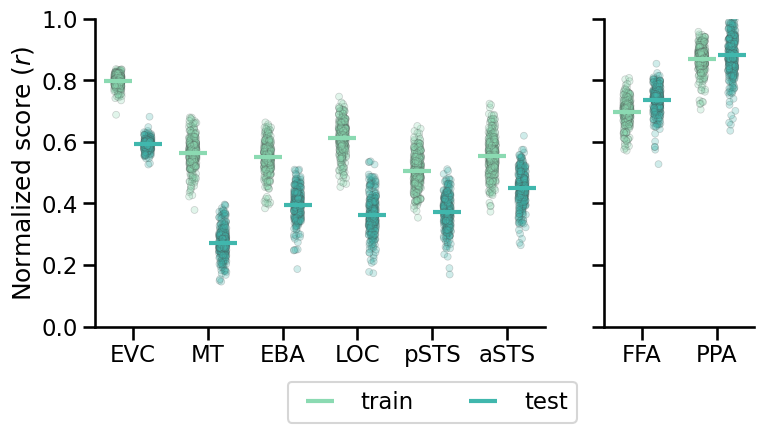

In [81]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/605010439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/605010439.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_364818/605010439.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/605010439.py:12: SettingWi

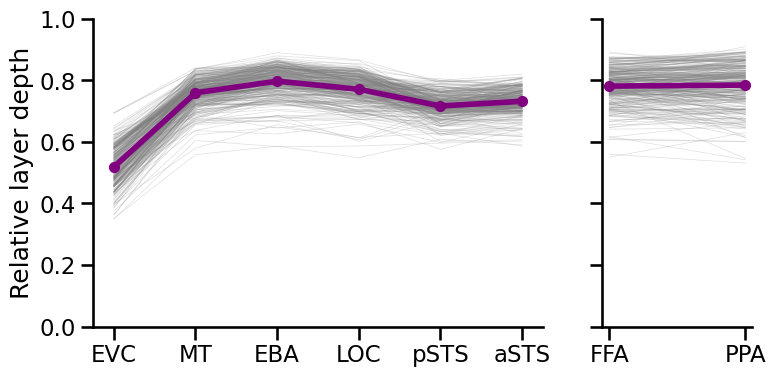

In [12]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}
max_scores_test = max_scores[max_scores.set == 'test']

for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores_test[max_scores_test.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)

    sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                 marker='.', markersize=10, zorder=1, color='purple',
                 ax=ax, legend=False)
    sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                 data=cur_scores, ax=ax,
                 linewidth=.5, alpha=0.25, zorder=0,
                 legend=False, palette=color_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    if i_ax == 0:
        ax.set_ylabel('Relative layer depth')

## Language Models

### Behavior

In [13]:
files = glob(f'../data/interim/LanguageBehaviorEncoding/*.csv.gz')
print(f'{len(files)} behavioral encoding models found')
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

5 behavioral encoding models found


In [14]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [15]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_364818/2405867124.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


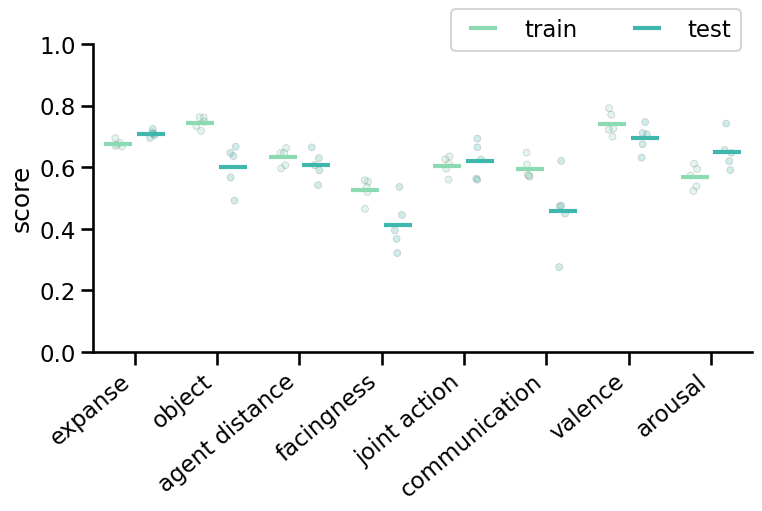

In [16]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xlabel('')
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.set_ylim([0,1])
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
          ncol=2, fancybox=True)

### Neural

In [17]:
files = glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df).reset_index(drop=True)

15 neural encoding models found


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


In [18]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

/tmp/ipykernel_364818/3571978288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/3571978288.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/3571978288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tm

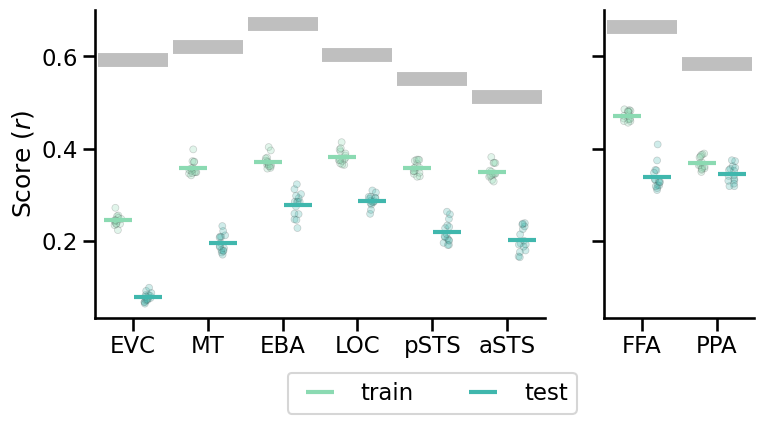

In [19]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=50, markeredgewidth=10,
                  color='gray', alpha=.5, zorder=1)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/873357488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/873357488.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/873357488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/i

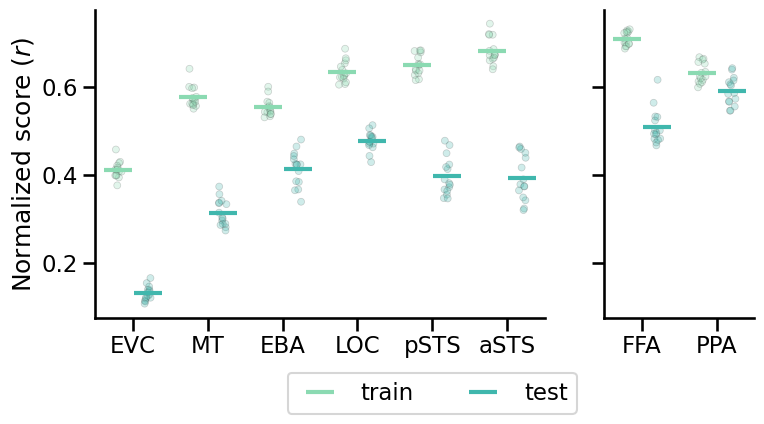

In [20]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/605010439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/605010439.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_364818/605010439.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/605010439.py:12: SettingWi

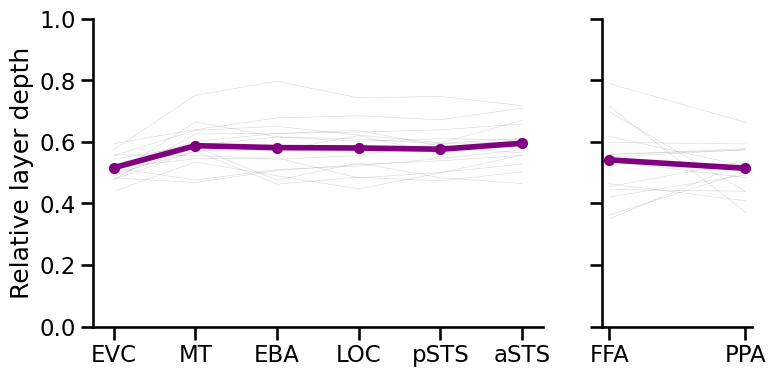

In [21]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}
max_scores_test = max_scores[max_scores.set == 'test']

for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores_test[max_scores_test.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)

    sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                 marker='.', markersize=10, zorder=1, color='purple',
                 ax=ax, legend=False)
    sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                 data=cur_scores, ax=ax,
                 linewidth=.5, alpha=0.25, zorder=0,
                 legend=False, palette=color_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    if i_ax == 0:
        ax.set_ylabel('Relative layer depth')

## Combined models

### Behavior

In [61]:
file

'../data/interim/LanguageBehaviorEncoding/model-gpt2.pkl.gz'

In [74]:
files = glob(f'../data/interim/VisionBehaviorEncoding/grouped_average/*.*.gz')
files += glob(f'../data/interim/LanguageBehaviorEncoding/*.*.gz')
files += glob(f'../data/interim/VideoBehaviorEncoding/*.*.gz')
print(f'{len(files)} behavior encoding models found')
df = []
for file in tqdm(files):
    try: 
        if 'csv' in file: 
            cdf = pd.read_csv(file)
        else:
            cdf = pd.read_pickle(file) 
    except:
        print(f'could not load {file.split('/')[-1]}')
        
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    elif 'Video' in file: 
        cdf['model_class'] = 'video'
        
    if 'r_var_dist' in cdf.columns.tolist():
        cdf.drop(columns=['r_var_dist', 'r_null_dist'], inplace=True)
    df.append(cdf)
df = pd.concat(df)

349 behavior encoding models found


 93%|█████████▎| 324/349 [00:02<00:00, 155.27it/s]

could not load model-gpt2.pkl.gz


100%|██████████| 349/349 [00:07<00:00, 44.12it/s] 


In [82]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
# max_scores.dropna(inplace=True)
# rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
# max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
# max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'video', 'language'], ordered=True)

In [85]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]
df.groupby(['feature', 'model_uid']).apply(get_max_score)

0  \
feature               model_uid                                                          
rating-agent_distance bit_expert_abstraction model_uid          bit_expert_abstraction   
                                             model_layer         PreActBottleneck-3-15   
                                             model_layer_index                     155   
                                             feature             rating-agent_distance   
                                             train_score                      0.642042   
...                                                                                ...   
rating-valence        x3d_xs                 model_layer_index                     420   
                                             feature                    rating-valence   
                                             train_score                       0.43748   
                                             test_score                       0.463684   
                                             model_class                         video   

                                                               model_uid  \
feature               model_uid                                            
rating-agent_distance bit_expert_abstraction model_uid               NaN   
                                             model_layer             NaN   
                                             model_layer_index       NaN   
                                             feature                 NaN   
                                             train_score             NaN   
...                                                                  ...   
rating-valence        x3d_xs                 model_layer_index       NaN   
                                             feature                 NaN   
                                             train_score             NaN   
                                             test_score              NaN   
                                             model_class             NaN   

                                                               model_layer  \
feature               model_uid                                              
rating-agent_distance bit_expert_abstraction model_uid                 NaN   
                                             model_layer               NaN   
                                             model_layer_index         NaN   
                                             feature                   NaN   
                                             train_score               NaN   
...                                                                    ...   
rating-valence        x3d_xs                 model_layer_index         NaN   
                                             feature                   NaN   
                                             train_score               NaN   
                                             test_score                NaN   
                                             model_class               NaN   

                                                                model_layer_index  \
feature               model_uid                                                     
rating-agent_distance bit_expert_abstraction model_uid                        NaN   
                                             model_layer                      NaN   
                                             model_layer_index                NaN   
                                             feature                          NaN   
                                             train_score                      NaN   
...                                                                           ...   
rating-valence        x3d_xs                 model_layer_index                NaN   
                                             feature                          NaN   
                                             train_score    

In [ ]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='test_score', hue='model_class', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
strip_collections = ax.collections
sns.pointplot(x='feature', y='test_score', hue='model_class', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
# ax.legend(loc='lower center', bbox_to_anchor=(0.4, -.35),
#           ncol=2, fancybox=True)

### Neural

In [44]:
files = glob(f'../data/interim/VisionNeuralEncoding/grouped_average/*.csv.gz')
files += glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
files += glob(f'../data/interim/LanguageNeuralEncoding/*.pkl.gz')
files += glob(f'../data/interim/VideoNeuralEncoding/*.pkl.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    if 'csv' in file: 
        cdf = pd.read_csv(file)
    else:
        cdf = pd.read_pickle(file) 
        
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    elif 'Video' in file: 
        cdf['model_class'] = 'video'
        
    if 'r_var_dist' in cdf.columns.tolist():
        cdf.drop(columns=['r_var_dist', 'r_null_dist'], inplace=True)
    
    cdf = cdf[cdf['roi_name'] != 'none'].reset_index(drop=True)
    df.append(cdf)
df = pd.concat(df)
df['normalized_score'] = df['test_score'] / df['reliability']
df.head()

351 neural encoding models found


100%|██████████| 351/351 [02:19<00:00,  2.52it/s]


,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer_relative_depth,layer,train_score,model_uid,test_score,model_class,normalized_score
0,108,pSTS,high_lateral,1,0.384594,4,30,36,76,0.189055,Linear-6-57,0.232495,timm_mvitv2_base,0.066880,vision,0.173898
1,237,pSTS,high_lateral,1,0.580704,5,28,36,388,0.965174,Linear-6-330,0.161965,timm_mvitv2_base,0.079379,vision,0.136694
2,238,pSTS,high_lateral,1,0.578962,5,28,37,274,0.681592,Linear-6-232,0.249373,timm_mvitv2_base,0.235356,vision,0.406513
3,239,pSTS,high_lateral,1,0.666494,5,28,38,29,0.072139,LayerNorm-6-21,0.313365,timm_mvitv2_base,0.036749,vision,0.055138
4,244,pSTS,high_lateral,1,0.481124,5,29,36,76,0.189055,Linear-6-57,0.180351,timm_mvitv2_base,0.074278,vision,0.154384


In [45]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)

max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'video', 'language'], ordered=True)

In [58]:
max_scores_index = max_scores.set_index(['roi_name', 'model_class', 'model_uid'])['test_score']
model_uids_to_annotate = ['gpt2']
model_uids_to_annotate += [max_scores_index.loc['pSTS', 'vision'].idxmax()]
model_uids_to_annotate += [max_scores_index.loc['pSTS', 'video'].idxmax()]
model_uids_to_annotate += [max_scores_index.loc['pSTS', 'language'].idxmax()]
print(model_uids_to_annotate)
model_name_to_show = ['gpt2', 'beitv2', 'c2d_r50', 'distiluse']
rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
offset_positions = [(-10, -35), (-15, 40), (0, 55), (25, 40)]
offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
annotation_roi = 'pSTS'
dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter

['gpt2', 'timm_beitv2_large_patch16_224', 'c2d_r50', 'sentence-transformers_distiluse-base-multilingual-cased-v1']


/tmp/ipykernel_3639335/2189632731.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  model_uids_to_annotate += [max_scores_index.loc['pSTS', 'vision'].idxmax()]
/tmp/ipykernel_3639335/2189632731.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  model_uids_to_annotate += [max_scores_index.loc['pSTS', 'video'].idxmax()]
/tmp/ipykernel_3639335/2189632731.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  model_uids_to_annotate += [max_scores_index.loc['pSTS', 'language'].idxmax()]


/tmp/ipykernel_3639335/780425140.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_3639335/780425140.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_3639335/780425140.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/

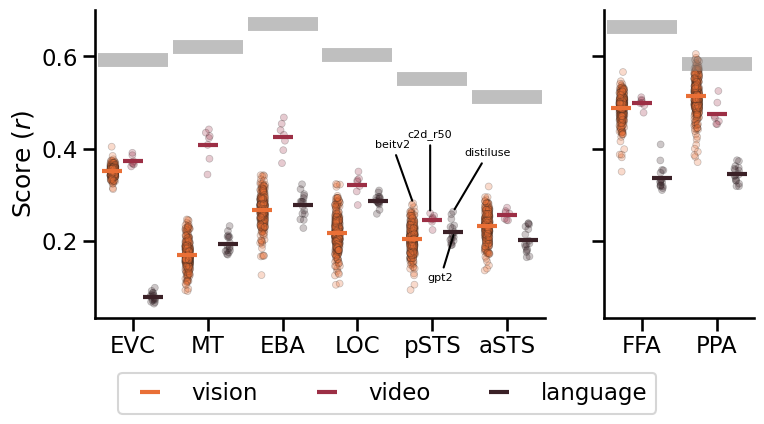

In [59]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                          [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                           ['FFA', 'PPA']])):
    legend = True if i_ax == 0 else False
    roi_positions = {roi: i for i, roi in enumerate(cur_rois)}

    cur_scores = max_scores[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='test_score', hue='model_class', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=50, markeredgewidth=10,
              alpha=.5, zorder=1, ax=ax)
    sns.pointplot(x='roi_name', y='test_score', hue='model_class',
                  data=cur_scores, legend=legend,
                  ax=ax, dodge=.55, linestyle="none", errorbar=None,
                  marker="_", markersize=14, markeredgewidth=3, zorder=1)
        
    # Loop through the DataFrame and annotate the points for select model_uids
    for _, row in cur_scores.iterrows():
        if (row['model_uid'] in model_uids_to_annotate and row['roi_name'] == annotation_roi):
            # Get the index of the relevant stripplot
            c_names = list(product(cur_rois, list(cur_scores.model_class.unique())))
            matching_index = [index for index, (roi, mclass) in enumerate(c_names) if roi == annotation_roi and mclass == row['model_class']][0]
            stripplot_points = strip_collections[matching_index].get_offsets()

            # Find the closest point to the intended test_score
            closest_point_idx = np.where(np.isclose(stripplot_points[:, 1], row['test_score']))[0][0]
            closest_point = stripplot_points[closest_point_idx]

            ax.annotate(rename_mapping[row['model_uid']],
                        xy=closest_point,  # Use the closest stripplot point
                        xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
                        textcoords='offset points',
                        ha='center',
                        fontsize=8,  # Adjust the text size if needed
                        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))
            
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.65, -.35),
                  ncol=3, fancybox=True)

/tmp/ipykernel_3627965/2421956515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_3627965/2421956515.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_3627965/2421956515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


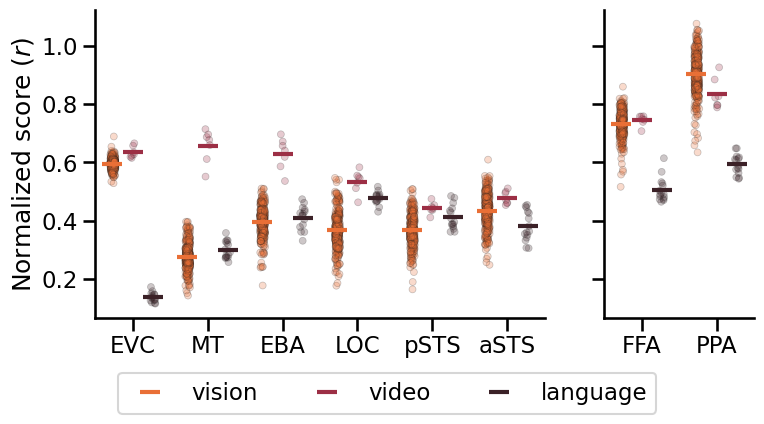

In [26]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='model_class', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='model_class',
                      data=cur_scores, legend=True,
                      ax=ax, dodge=.55, linestyle="none", errorbar=None,
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='model_class',
                      data=cur_scores, legend=False,
                      ax=ax, dodge=.55, linestyle="none", errorbar=None,
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.65, -.35),
                  ncol=3, fancybox=True)